In [1]:
! pip install pyDOE


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.autograd as autograd         
from torch import Tensor                  
import torch.nn as nn                     
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import time
from pyDOE import lhs
from math import pi
from mpl_toolkits.mplot3d import Axes3D
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
steps=2000
lr=0.0001
layers = np.array([2,32,32,32,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

In [4]:
def f_real(x,t):
    return torch.pow(t,2) + torch.sin(pi*x)

In [5]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
y_real=f_real(X,T)
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


C:\Users\varun\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


C:\Users\varun\AppData\Local\Temp\ipykernel_17816\3834245849.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


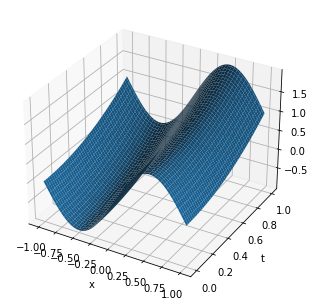

Actual Function


In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, T, y_real)
plt.xlabel('x')
plt.ylabel('t')
plt.show()
print("Actual Function")

In [7]:
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None] , T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None]
lb=x_test[0]
ub=x_test[-1]
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


In [8]:
left_x=torch.hstack((X[:,0][:,None] , T[:,0][:,None]))
left_y=torch.sin(pi*left_x[:,0]).unsqueeze(1)
print(left_x.shape)
bottom_x=torch.hstack((X[-1,:][:,None] , T[-1,:][:,None]))
bottom_y=torch.zeros(bottom_x.shape[0],1)
print(bottom_x.shape)
top_x=torch.hstack((X[0,:][:,None] , T[0,:][:,None]))
top_y=torch.zeros(top_x.shape[0],1)
print(top_x.shape)
X_train=torch.vstack([left_x,bottom_x,top_x])
Y_train=torch.vstack([left_y,bottom_y,top_y])
print(X_train.shape)
print(Y_train.shape)

torch.Size([200, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([400, 2])
torch.Size([400, 1])


In [9]:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

In [10]:
X_train_Nf=lb+(ub-lb)*lhs(2,Nf)
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu))
f_hat=torch.zeros(X_train_Nf.shape[0],1)

In [11]:
X_train_Nu=X_train_Nu.float().to(device)
Y_train_Nu=Y_train_Nu.float().to(device)
X_train_Nf=X_train_Nf.float().to(device)
f_hat=f_hat.float().to(device)
X_test=x_test.float().to(device)
Y_test=y_test.float().to(device)

In [12]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()  
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    def lossBC(self,x_BC,y_BC):
        loss_BC=self.loss_function(self.forward(x_BC),y_BC)
        return loss_BC
    
    def lossPDE(self,x_PDE):
        g=x_PDE.clone()
        g.requires_grad=True 
        f=self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]
        f_t=f_x_t[:,[1]]
        f_xx=f_xx_tt[:,[0]] 
        f=f-(1/4)*torch.pow(f_t,2) + (1/(pi*pi)*f_xx) 
        return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
        loss_bc=self.lossBC(x_BC,y_BC)
        loss_pde=self.lossPDE(x_PDE)
        return loss_bc+loss_pde
    
    def closure(self):
        optimizer.zero_grad()  
        loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
        loss.backward()      
        self.iter += 1
        if self.iter % 100 == 0:
            loss2=self.lossBC(X_test,Y_test)
            print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
        return loss   

In [13]:
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
for i in range(steps):
    if i==0:
        print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
        with torch.no_grad():
            test_loss=PINN.lossBC(X_test,Y_test)
            print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
0.2745782 --- 0.7280517
0.18021907 --- 0.5992587
0.107343 --- 0.42661387
0.044030882 --- 0.27859613
0.013766273 --- 0.21228193
0.0071707135 --- 0.19966386
0.0036117358 --- 0.19643886
0.002357036 --- 0.19727233
0.0019999018 --- 0.1984597
0.0017626879 --- 0.19855185


In [15]:
y_pred=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

In [16]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_t1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_pred=y_pred.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

C:\Users\varun\AppData\Local\Temp\ipykernel_17816\101017758.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


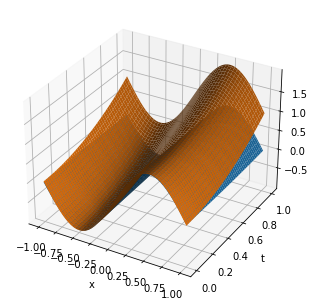

Orange->Actual Function
Blue->Predicted Function


In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(arr_x1, arr_t1, arr_y_pred)
ax.plot_surface(X, T, y_real)
plt.xlabel('x')
plt.ylabel('t')
plt.show()
print("Orange->Actual Function")
print("Blue->Predicted Function")